In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px # 파이썬의 시각화 라이브러리
import matplotlib.pyplot as plt
import plotly.graph_objects as go # 그래프 그리기
from plotly.subplots import make_subplots

from sklearn.impute import SimpleImputer # 결측치 대치 파라미터
from sklearn.metrics import accuracy_score # 정확도 평가
from sklearn.preprocessing import LabelEncoder # 문자를 숫자로
from sklearn.model_selection import StratifiedKFold, train_test_split # 교차 검증

from lightgbm import LGBMClassifier
import lazypredict # 머신러닝 자동화 관련 파이썬 오픈소스
from lazypredict.Supervised import LazyClassifier

import time # 시간 데이터
import warnings # 경고 제어
warnings.filterwarnings('ignore') # 경고 메시지 무시하기

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

RANDOM_STATE = 12
FOLDS = 5
STRATEGY = 'median'

# imputation - strategy는 결측값을 채우기 위해 사용됨
# median 외에도 mean, most_frequent, constant가 기본적으로 제공됨

In [4]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [5]:
print(f'\033[94mNumber of rows in train data: {train.shape[0]}')
print(f'\033[94mNumber of columns in train data: {train.shape[1]}')
print(f'\033[94mNumber of values in train data: {train.count().sum()}')
print(f'\033[94mNumber missing values in train data: {sum(train.isna().sum())}')

Number of rows in train data: 8693
Number of columns in train data: 14
Number of values in train data: 119378
Number missing values in train data: 2324


In [6]:
 print(f'\033[94m')
print(train.isna().sum().sort_values(ascending = False)) # 내림차순


CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64


In [7]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [8]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez


In [9]:
print(f'\033[94mNumber of rows in test data: {test.shape[0]}')
print(f'\033[94mNumber of columns in test data: {test.shape[1]}')
print(f'\033[94mNumber of values in train data: {test.count().sum()}')
print(f'\033[94mNo of rows with missing values in test data: {sum(test.isna().sum())}')

Number of rows in test data: 4277
Number of columns in test data: 13
Number of values in train data: 54484
No of rows with missing values in test data: 1117


In [10]:
print(f'\033[94m')
print((test.isna().sum().sort_values(ascending = False))) # 내림차순


FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


In [11]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


In [12]:
submission.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [13]:
# pd.drop() : 데이터 삭제
# axis = 0 : 행 삭제, axis = 1 : 열 삭제
# inplace = True : 지우려고 하는 column까지 삭제

train.drop(["PassengerId"], axis = 1, inplace = True)
test.drop(["PassengerId"], axis = 1, inplace = True)
TARGET = 'Transported'
FEATURES = [col for col in train.columns if col != TARGET]
RANDOM_STATE = 12

In [14]:
# df.iloc[] : 값 추출
# T(Transformation) : 행과 열을 바꿔주는 함수
# sort_values : 값 정렬
# ascending = True : 오름차순, ascending = False : 내림차순
# by : 정렬 기준이 될 레이블
# std : 표준편차
# style.background_gradient : 수치의 크기를 색상 온도로 보는 함수
# cmap : colormap
# bar : 막대 옵션 변경
# "max" 행의 color를 '#BB0000', "mean" 행의 color를 'grean'으로 설정

#train.iloc[:, :-1].describe().T.sort_values(by='std', ascending = False)\
#.style.background_gradient(cmap='GuBu')\
#.bar(subset=["max"], color = '#BB0000')\
#.bar(subset=["mean"], color = 'grean')

In [15]:
# make_subplots : 함수를 사용해 subplot 생성
# rows, cols : 몇 행, 몇 열로 그릴지 설정
# add_trace : 새로운 그래프를 겹쳐 그릴 때 사용
# orientation : 그래프 수평으로 그리기
# update_layout : 그래프 생성 후 layout 정보 업데이트
# showlegend = False : 범례 표시하지 않기

test_null = pd.DataFrame(test.isna().sum())
test_null = test_null.sort_values(by = 0, ascending = False)
train_null = pd.DataFrame(train.isna().sum())
train_null = train_null.sort_values(by=0, ascending = False)[:-1]

fig = make_subplots(rows=1, cols = 2, column_titles = ["Train Data", "Test Data"],
                   x_title = "Missing Values")

fig.add_trace(go.Bar(x=train_null[0], y=train_null.index, orientation="h",
                    marker=dict(color=[n for n in range(12)],
                                line_color = 'rgb(0,0,0)', line_width = 2,
                               coloraxis="coloraxis")), 1, 1)
fig.add_trace(go.Bar(x=test_null[0], y=test_null.index, orientation="h",
                    marker=dict(color=[n for n in range(12)],
                                line_color='rgb(0,0,0)', line_width = 2,
                               coloraxis="coloraxis")), 1, 2)

fig.update_layout(showlegend=False, title_text="Column wise Null Value Distribution", title_x = 0.5)

In [19]:
# reset_index : 설정 인덱스를 제거하고 기본 인덱스(0,1,2, ... , n)으로 변경하는 메서드

missing_train_row = train.isna().sum(axis=1)
missing_train_row = pd.DataFrame(missing_train_row.value_counts()/train.shape[0]).reset_index()
missing_test_row = test.isna().sum(axis=1)
missing_test_row = pd.DataFrame(missing_test_row.value_counts()/test.shape[0]).reset_index()
missing_train_row.columns = ['no', 'count']
missing_test_row.columns = ['no', 'count']
missing_train_row["count"] = missing_train_row["count"]*100
missing_test_row["count"] = missing_test_row["count"]*100

fig = make_subplots(rows=1, cols=2, column_titles = ["Train Data", "Test Data"],
                   x_title = "Missing Values")
fig.add_trace(go.Bar(x = missing_train_row["no"], y=missing_train_row["count"],
                    marker = dict(color = [n for n in range(4)], line_color = 'rgb(0,0,0)',
                                 line_width=3, coloraxis="coloraxis")), 1,1)
fig.add_trace(go.Bar(x = missing_test_row["no"], y=missing_test_row["count"],
                    marker = dict(color = [n for n in range(4)], line_color = 'rgb(0,0,0)',
                                 line_width=3, coloraxis = "coloraxis")), 1,2)
fig.update_layout(showlegend=False, title_text = "Row wise Null Value Distribution", title_x=0.5)

In [20]:
# pd.concat : pandas의 DataFrame 합치는 방법
# axis = 0 : 위, 아래로 합치기
# axis = 1 : 왼쪽, 오른쪽으로 합치기
# nunique() : 데이터에 고유값들의 수를 출력해주는 함수
# go.Figure() : 기본 그래프 생성
# go.Pie() : Pie Chart 그리기
# pull : 조각 별 거리

df = pd.concat([train[FEATURES], test[FEATURES]], axis = 0)
text_features = ["Cabin", "Name"]
cat_features = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_features]
cont_features = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_features]

del df
print(f'\033[94mTotal number of features: {len(FEATURES)}')
print(f'\033[94mNumber of categorical features: {len(cat_features)}')
print(f'\033[94mNumber of continuos features: {len(cont_features)}')
print(f'\033[94mNumber of text features: {len(text_features)}')

labels = ['Categorical', 'Continuos', "Text"]
values = [len(cat_features), len(cont_features), len(text_features)]
colors = ['#DE3163', '#58D68D']

fig = go.Figure(data = [go.Pie(labels=labels, values = values, pull = [0.1, 0, 0],
                              marker = dict(colors = colors, line=dict(color='#000000', width = 2)))])

fig.show()

Total number of features: 12
Number of categorical features: 4
Number of continuos features: 6
Number of text features: 2


In [21]:
# histogram : 순서형 자료와 수치형 자료를 도수분포표를 이용해 그래프로 나타냄
# color_discrete_sequence : 불연속 그래프의 색 지정
# nbins : 영역을 몇개로 나눌지 설정
# fig.update_layout :  생성 후 layout 정보 업데이트

train_age = train.copy()
test_age = test.copy()
train_age["type"] = "Train"
test_age["type"] = "Test"
ageDf = pd.concat([train_age, test_age])
fig = px.histogram(data_frame = ageDf, x = "Age", color = "type", color_discrete_sequence = ['#58D68D', '#DE3163'],
                  marginal = "box", nbins=100, template="plotly_white")
fig.update_layout(title = "Distribution of Age", title_x = 0.5)
fig.show()

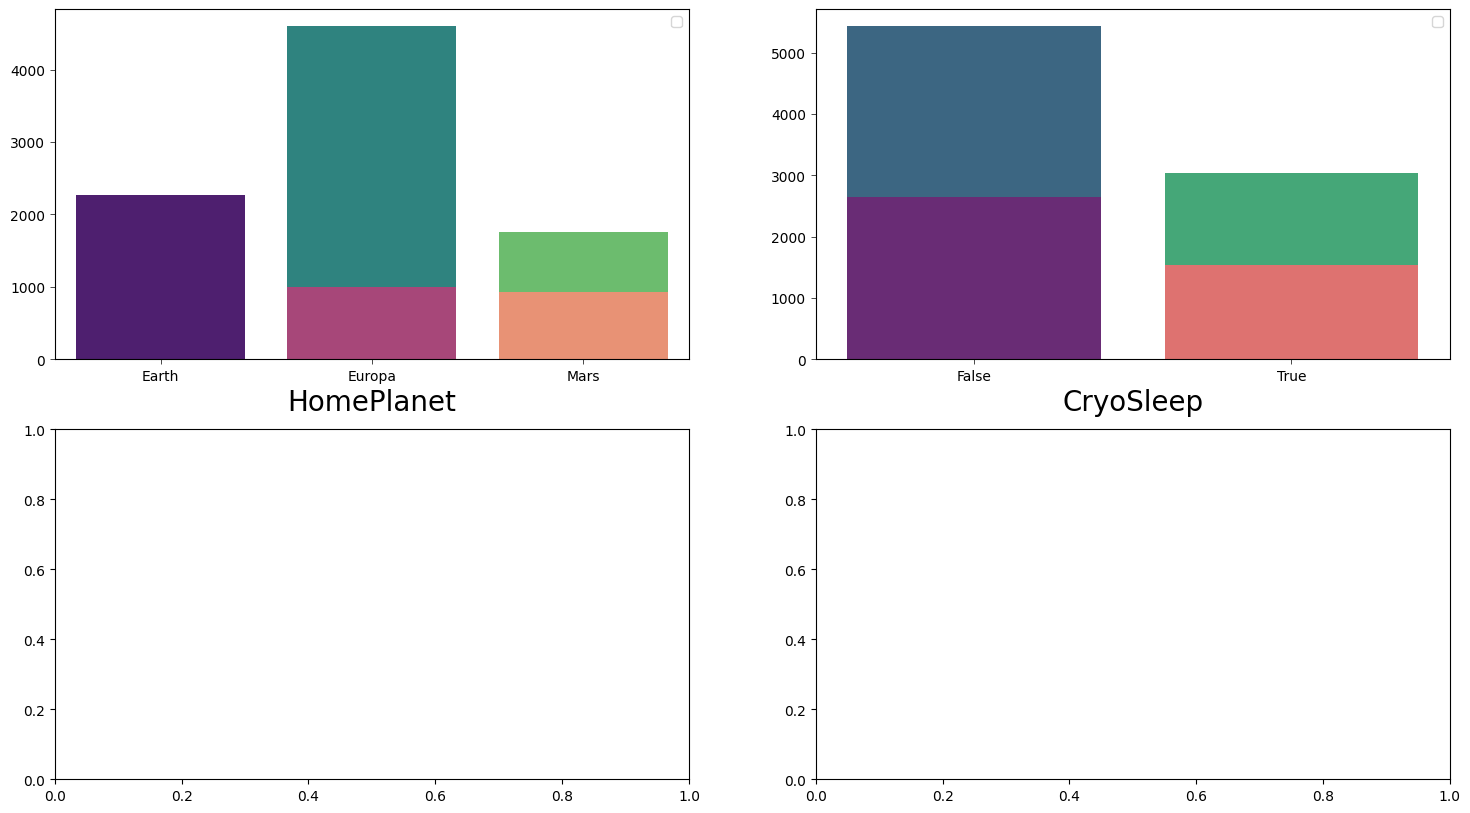

In [22]:
# sns.countplot : 데이터프레임에서 원하는 열의 각각 고유한 값의 개수를 세어 그래프에 표현
# tick_params : 축 설정

if len(cat_features) == 0:
    print("No Categorical features")
else:
    ncols = 2
    nrows = 2
    
    fig, axes = plt.subplots(nrows, ncols, figsize = (18,10))
    for r in range(nrows):
        for c in range(ncols):
            col = cat_features[r*ncols+c]
            sns.countplot(train[col], ax=axes[r,c], x = train[col], palette="viridis")
            sns.countplot(test[col], ax=axes[r,c], x = test[col], palette="magma")
            axes[r,c].legend()
            axes[r,c].set_ylabel('')
            axes[r,c].set_xlabel(col, fontsize=20)
            axes[r,c].tick_params(labelsize=10, width=0.5)
            axes[r,c].xaxis.offsetText.set_fontsize(4)
            axes[r,c].yaxis.offsetText.set_fontsize(4)
        plt.show()

In [23]:
# value_counts : 열의 각 값에 대한 모든 발생 횟수 반환
# reset_index : 인덱스 재배열

target_df = pd.DataFrame(train[TARGET].value_counts()).reset_index()
target_df.columns = [TARGET, 'count']
fig = px.bar(data_frame = target_df, x=TARGET, y='count')
fig.update_traces(marker_color = ['#58D68D', '#DE3163'], marker_line_color = 'rgb(0,0,0)', marker_line_width=2, )

fig.update_layout(title = "Target Distribution", template = "plotly_white", title_x = 0.5)
print("\033[94mPercentage of Transported = 0: {:.2f} %".format(target_df["count"][0]*100/train.shape[0]))
print("\033[94mPercentage of Transported = 1: {:.2f} %".format(target_df["count"][1]*100/test.shape[0]))

Percentage of Transported = 0: 50.36 %
Percentage of Transported = 1: 100.89 %


In [26]:
# imshow : array의 값을 색으로 환산해 이미지 형태로 보여줌

#fig = px.imshow(train.corr(), text_auto=True, aspect="auto", color_continuous_scale = "viridis")
#fig.show()

In [27]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "RoomService"]
imputer = SimpleImputer(strategy = STRATEGY) # 결측값 중간값으로 채우는 설정
imputer.fit(train[imputer_cols]) # 중간값 계산
train[imputer_cols] = imputer.transform(train[imputer_cols]) # 변형된 특성 있는 배열 넣음
test[imputer_cols] = imputer.transform(test[imputer_cols])
train["HomePlanet"].fillna('Z', inplace = True) # NaN값 Z로 채우기
test["HomePlanet"].fillna('Z', inplace = True)

In [28]:
label_cols = ["HomePlanet", "CryoSleep", "Cabin", "Destination", "VIP"]
def label_encoder(train, test, columns):
    for col in columns:
        train[col] = train[col].astype(str) # 문자형으로 변경
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

train, test = label_encoder(train, test, label_cols)

In [29]:
train.drop(["Name", "Cabin"], axis = 1, inplace = True) # 버리기
test.drop(["Name", "Cabin"], axis = 1, inplace = True)
X = train.drop(TARGET, axis = 1)
y = train[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 12, test_size = 0.33)